# 臉部偵測

## 使用SDK偵測影像中的人臉


Detected face ID from detection1.jpg :
ce3a68c7-fc8d-4e76-910a-8df6c883a674

Facial attributes detected:
Age: 24.0
Gender: Gender.female
Head pose: {'additional_properties': {}, 'roll': -13.6, 'yaw': 5.0, 'pitch': -12.0}
Smile: 1.0
Facial hair: {'additional_properties': {}, 'moustache': 0.0, 'beard': 0.0, 'sideburns': 0.0}
Glasses: GlassesType.reading_glasses
Emotion: {'additional_properties': {}, 'anger': 0.0, 'contempt': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happiness': 1.0, 'neutral': 0.0, 'sadness': 0.0, 'surprise': 0.0}

Drawing rectangle around face...


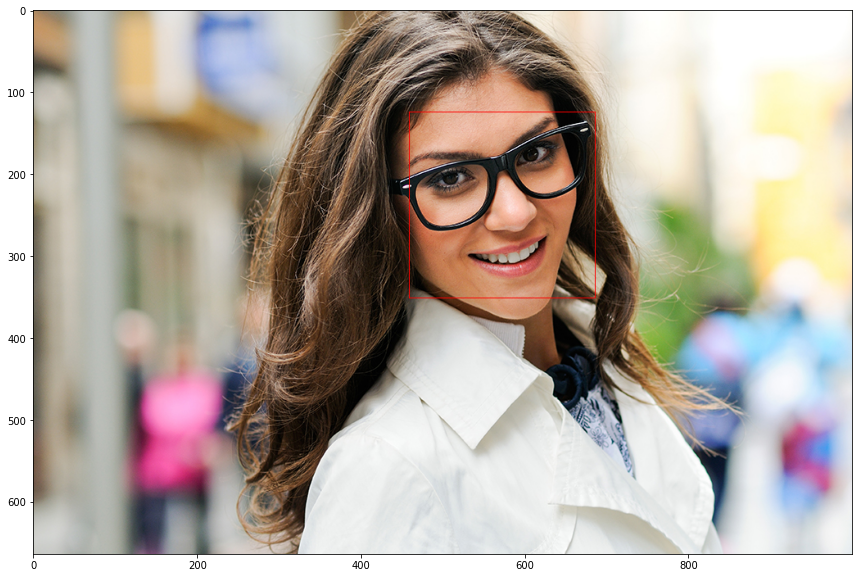

In [1]:
from io import BytesIO
import os
from PIL import Image, ImageDraw
import requests
from matplotlib import pyplot as plt
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import FaceAttributeType
from msrest.authentication import CognitiveServicesCredentials

'''
Authenticate the Face service
'''
KEY = '8b361049be23449391869bdb83839edb'
ENDPOINT = 'https://facialrecogexample.cognitiveservices.azure.com/'

# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))


'''
Detect face(s) with attributes in a URL image
'''
# Image of face(s)
face1_url = 'https://raw.githubusercontent.com/Microsoft/Cognitive-Face-Windows/master/Data/detection1.jpg'
face1_name = os.path.basename(face1_url)


# List of url images
url_images = [face1_url]

# Attributes you want returned with the API call, a list of FaceAttributeType enum (string format)
face_attributes = ['age', 'gender', 'headPose', 'smile', 'facialHair', 'glasses', 'emotion']

# Detect a face with attributes, returns a list[DetectedFace]
for image in url_images:
    detected_faces = face_client.face.detect_with_url(url=image, return_face_attributes=face_attributes)
    if not detected_faces:
        raise Exception(
            'No face detected from image {}'.format(os.path.basename(image)))

    '''
    Display the detected face with attributes and bounding box
    '''
    # Face IDs are used for comparison to faces (their IDs) detected in other images.
    for face in detected_faces:
        print()
        print('Detected face ID from', os.path.basename(image), ':')
        # ID of detected face
        print(face.face_id)
        # Show all facial attributes from the results
        print()
        print('Facial attributes detected:')
        print('Age:', face.face_attributes.age)
        print('Gender:', face.face_attributes.gender)
        print('Head pose:', face.face_attributes.head_pose)
        print('Smile:', face.face_attributes.smile)
        print('Facial hair:', face.face_attributes.facial_hair)
        print('Glasses:', face.face_attributes.glasses)
        print('Emotion:', face.face_attributes.emotion)
        print()

    # Convert width height to a point in a rectangle
    def getRectangle(faceDictionary):
        rect = faceDictionary.face_rectangle
        left = rect.left
        top = rect.top
        right = left + rect.width
        bottom = top + rect.height

        return ((left, top), (right, bottom))

    # Download the image from the url, so can display it in popup/browser
    response = requests.get(image)
    img = Image.open(BytesIO(response.content))

    # For each face returned use the face rectangle and draw a red box.
    print('Drawing rectangle around face...')
    draw = ImageDraw.Draw(img)
    for face in detected_faces:
        draw.rectangle(getRectangle(face), outline='red')

    # Display the image in jupyter notebook.
    plt.figure(figsize=(600,10))
    plt.imshow(img)
    plt.show()

## 使用REST API回傳偵測結果

In [2]:
import requests
import json

KEY = '8b361049be23449391869bdb83839edb'
ENDPOINT = 'https://facialrecogexample.cognitiveservices.azure.com/face/v1.0/detect'

# set to your own subscription key value
subscription_key = KEY
assert subscription_key

# replace <My Endpoint String> with the string from your endpoint URL
face_api_url = ENDPOINT #'https://<My Endpoint String>.com/face/v1.0/detect'


image_url = 'https://raw.githubusercontent.com/Microsoft/Cognitive-Face-Windows/master/Data/detection1.jpg'

headers = {'Ocp-Apim-Subscription-Key': subscription_key}

params = {
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'false',
    'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
}

response = requests.post(face_api_url, params=params,
                         headers=headers, json={"url": image_url})
print(json.dumps(response.json()))

[{"faceId": "62b7a9ee-f5f1-479e-b7cf-b442f7ea449f", "faceRectangle": {"top": 124, "left": 459, "width": 227, "height": 227}, "faceAttributes": {"smile": 1.0, "headPose": {"pitch": -12.0, "roll": -13.6, "yaw": 5.0}, "gender": "female", "age": 24.0, "facialHair": {"moustache": 0.0, "beard": 0.0, "sideburns": 0.0}, "glasses": "ReadingGlasses", "emotion": {"anger": 0.0, "contempt": 0.0, "disgust": 0.0, "fear": 0.0, "happiness": 1.0, "neutral": 0.0, "sadness": 0.0, "surprise": 0.0}, "blur": {"blurLevel": "low", "value": 0.0}, "exposure": {"exposureLevel": "goodExposure", "value": 0.48}, "noise": {"noiseLevel": "low", "value": 0.11}, "makeup": {"eyeMakeup": true, "lipMakeup": true}, "accessories": [{"type": "glasses", "confidence": 1.0}], "occlusion": {"foreheadOccluded": false, "eyeOccluded": false, "mouthOccluded": false}, "hair": {"bald": 0.1, "invisible": false, "hairColor": [{"color": "brown", "confidence": 0.99}, {"color": "black", "confidence": 0.45}, {"color": "blond", "confidence": 

# 臉部辨識

## 建立與訓練臉部影像群組

In [3]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, SnapshotObjectType, OperationStatusType

'''
Authenticate the Face service
'''
KEY = '8b361049be23449391869bdb83839edb'
ENDPOINT = 'https://facialrecogexample.cognitiveservices.azure.com/'

# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

# Used in the Person Group Operations,  Snapshot Operations, and Delete Person Group examples.
# You can call list_person_groups to print a list of preexisting PersonGroups.
# SOURCE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
PERSON_GROUP_ID = 'my-unique-person-group'

# Used for the Snapshot and Delete Person Group examples.
TARGET_PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)

'''
Create the PersonGroup
'''
# Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

# Define woman friend
woman = face_client.person_group_person.create(PERSON_GROUP_ID, "Woman")
# Define man friend
man = face_client.person_group_person.create(PERSON_GROUP_ID, "Man")
# Define child friend
child = face_client.person_group_person.create(PERSON_GROUP_ID, "Child")


'''
Detect faces and register to correct person
'''
# Find all jpeg images of friends in working directory
woman_images = [file for file in glob.glob('*.jpg') if file.startswith("woman")]
man_images = [file for file in glob.glob('*.jpg') if file.startswith("man")]
child_images = [file for file in glob.glob('*.jpg') if file.startswith("child")]

# Add to a woman person
for image in woman_images:
    w = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, woman.person_id, w)

# Add to a man person
for image in man_images:
    m = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, man.person_id, m)

# Add to a child person
for image in child_images:
    ch = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, child.person_id, ch)
    
'''
Train PersonGroup
'''
print()
print('Training the person group...')
# Train the person group
face_client.person_group.train(PERSON_GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        sys.exit('Training the person group has failed.')
    time.sleep(5)


Person group: my-unique-person-group

Training the person group...
Training status: succeeded.



## Identify a face

In [5]:
'''
Identify a face against a defined PersonGroup
'''
# Group image for testing against
group_photo = 'test-image-person-group.jpg'
IMAGES_FOLDER = os.path.join(os.path.dirname(os.path.realpath(group_photo)))

# Get test image
test_image_array = glob.glob(os.path.join(IMAGES_FOLDER, group_photo))
image = open(test_image_array[0], 'r+b')

# Detect faces
face_ids = []
faces = face_client.face.detect_with_stream(image)
for face in faces:
    face_ids.append(face.face_id)
    
# Identify faces
results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
print('Identifying faces in {}'.format(os.path.basename(image.name)))
if not results:
    print('No person identified in the person group for faces from {}.'.format(os.path.basename(image.name)))
for person in results:
    print('Person for face ID {} is identified in {} with a confidence of {}.'.format(person.face_id, os.path.basename(image.name), person.candidates[0].confidence)) # Get topmost confidence score

Identifying faces in test-image-person-group.jpg
Person for face ID afa5ea71-cd25-4615-ac1b-8dd94582e3f7 is identified in test-image-person-group.jpg with a confidence of 0.92387.
Person for face ID 62abb154-16a5-4af1-8a2b-e84f3e6bb7b7 is identified in test-image-person-group.jpg with a confidence of 0.93316.


## Verify Faces from different images

In [6]:
# Base url for the Verify and Facelist/Large Facelist operations
IMAGE_BASE_URL = 'https://csdx.blob.core.windows.net/resources/Face/Images/'

# Create a list to hold the target photos of the same person
target_image_file_names = ['Family1-Dad1.jpg', 'Family1-Dad2.jpg']
# The source photos contain this person
source_image_file_name1 = 'Family1-Dad3.jpg'
source_image_file_name2 = 'Family1-Son1.jpg'

# Detect face(s) from source image 1, returns a list[DetectedFaces]
detected_faces1 = face_client.face.detect_with_url(IMAGE_BASE_URL + source_image_file_name1)

# Add the returned face's face ID
source_image1_id = detected_faces1[0].face_id
print('{} face(s) detected from image {}.'.format(len(detected_faces1), source_image_file_name1))

# Detect face(s) from source image 2, returns a list[DetectedFaces]
detected_faces2 = face_client.face.detect_with_url(IMAGE_BASE_URL + source_image_file_name2)

# Add the returned face's face ID
source_image2_id = detected_faces2[0].face_id
print('{} face(s) detected from image {}.'.format(len(detected_faces2), source_image_file_name2))

# List for the target face IDs (uuids)
detected_faces_ids = []
# Detect faces from target image url list, returns a list[DetectedFaces]
for image_file_name in target_image_file_names:
    detected_faces = face_client.face.detect_with_url(IMAGE_BASE_URL + image_file_name)
    # Add the returned face's face ID
    detected_faces_ids.append(detected_faces[0].face_id)
    print('{} face(s) detected from image {}.'.format(len(detected_faces), image_file_name))
    
    
# Verification example for faces of the same person. The higher the confidence, the more identical the faces in the images are.
# Since target faces are the same person, in this example, we can use the 1st ID in the detected_faces_ids list to compare.
verify_result_same = face_client.face.verify_face_to_face(source_image1_id, detected_faces_ids[0])
print('Faces from {} & {} are of the same person, with confidence: {}'
    .format(source_image_file_name1, target_image_file_names[0], verify_result_same.confidence)
    if verify_result_same.is_identical
    else 'Faces from {} & {} are of a different person, with confidence: {}'
        .format(source_image_file_name1, target_image_file_names[0], verify_result_same.confidence))


# Verification example for faces of different persons.
# Since target faces are same person, in this example, we can use the 1st ID in the detected_faces_ids list to compare.
verify_result_diff = face_client.face.verify_face_to_face(source_image2_id, detected_faces_ids[0])
print('Faces from {} & {} are of the same person, with confidence: {}'
    .format(source_image_file_name2, target_image_file_names[0], verify_result_diff.confidence)
    if verify_result_diff.is_identical
    else 'Faces from {} & {} are of a different person, with confidence: {}'
        .format(source_image_file_name2, target_image_file_names[0], verify_result_diff.confidence))

1 face(s) detected from image Family1-Dad3.jpg.
1 face(s) detected from image Family1-Son1.jpg.
1 face(s) detected from image Family1-Dad1.jpg.
1 face(s) detected from image Family1-Dad2.jpg.
Faces from Family1-Dad3.jpg & Family1-Dad1.jpg are of the same person, with confidence: 0.88193
Faces from Family1-Son1.jpg & Family1-Dad1.jpg are of a different person, with confidence: 0.26628


## 刪除訓練好的臉部辨識群組

In [7]:
# Delete the main person group.
face_client.person_group.delete(person_group_id=PERSON_GROUP_ID)
print("Deleted the person group {} from the source location.".format(PERSON_GROUP_ID))
print()

Deleted the person group my-unique-person-group from the source location.

